In [6]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sns

# Binary classification

In [2]:
def evaluate_models_with_cv(X, y, participants, k=25):
    """
    Evaluate models using SelectKBest for feature selection within a pipeline,
    using both LOGOCV and 5-Fold Cross-Validation.
    
    Parameters:
    - X: Features DataFrame
    - y: Target Series
    - participants: Group labels for LOGOCV
    - k: Number of top features to select
    
    Returns:
    - results: Dictionary with mean and std accuracy for each model and CV method
    """

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"),
        "SVM (RBF Kernel)": SVC(kernel="rbf", random_state=42, class_weight="balanced"),
        "Naive Bayes": GaussianNB()
    }

    cv_methods = {
        "LOGOCV": LeaveOneGroupOut(),
        "5-Fold": KFold(n_splits=5, shuffle=True, random_state=42)
    }

    scorer = make_scorer(accuracy_score)
    all_results = {}

    for cv_name, cv_splitter in cv_methods.items():
        print(f"\nEvaluating models with {cv_name}...")
        results = {}

        for model_name, model in models.items():
            print(f"Evaluating {model_name}...")

            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("select_kbest", SelectKBest(score_func=f_classif, k=k)),  # Select top k features
                ("classifier", model)
            ])

            if cv_name == "LOGOCV":
                cv = cv_splitter.split(X, y, groups=participants)
            else:  # For "5-Fold"
                cv = cv_splitter.split(X, y)

            cv_scores = cross_val_score(
                pipeline, X, y,
                cv=cv,
                scoring=scorer,
                n_jobs=1
            )

            results[model_name] = {
                "mean_accuracy": cv_scores.mean(),
                "std_accuracy": cv_scores.std()
            }
            print(f"{model_name}: Mean Accuracy = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        all_results[cv_name] = results
    return all_results

In [10]:
def plot_results_heatmap(results_data, models, datasets, cv_type):
    """
    Plot a heatmap of mean accuracies for multiple datasets and models.
    
    Parameters:
    - results_data: List of dictionaries with results for each dataset (IMU, EMG, IMU+EMG, etc.)
    - models: List of model names
    - datasets: List of dataset names (e.g., IMU, EMG, Video, IMU+EMG, etc.)
    - cv_type: Cross-validation type (e.g., "LOGOCV", "5-Fold")
    """
    # Check for mismatch in results_data and datasets
    if len(results_data) != len(datasets):
        raise ValueError(f"Mismatch between results_data ({len(results_data)}) and datasets ({len(datasets)})")

    mean_accuracies = [[results[model]["mean_accuracy"] for model in models] for results in results_data]
    heatmap_df = pd.DataFrame(mean_accuracies, columns=models, index=datasets)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_df, annot=True, fmt=".4f", cmap="YlGnBu", cbar_kws={'label': 'Accuracy'})
    plt.title(f"Model Performance Heatmap", fontsize=16)
    plt.ylabel("Dataset", fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.xticks(fontsize=10, rotation=45, ha="right")
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

## reps

In [12]:
df = pd.read_pickle("video_imu_emg_reps.pkl")
X = df.drop(columns=['Participant', 'Set', 'Repetition', 'Correct'])
y = df['Correct']
participants = df['Participant']

# Split into EMG, IMU, and Video based on column names
emg_columns = [col for col in X.columns if 'trapezius' in col or 'delt' in col]
video_columns = [col for col in X.columns if 'X' in col or 'Y' in col]
imu_columns = [col for col in X.columns if col not in emg_columns + video_columns]

X_emg = X[emg_columns]
X_video = X[video_columns]
X_imu = X[imu_columns]
X_imu_emg = X[imu_columns + emg_columns]
X_imu_video = X[imu_columns + video_columns]
X_emg_video = X[emg_columns + video_columns]
X_all = X  # All features (IMU + EMG + Video)

# Evaluate for IMU data
print("\nEvaluating IMU data:")
results_imu = evaluate_models_with_cv(X_imu, y, participants, k=25)

# Evaluate for EMG data
print("\nEvaluating EMG data:")
results_emg = evaluate_models_with_cv(X_emg, y, participants, k=25)

# Evaluate for Video data
print("\nEvaluating Video data:")
results_video = evaluate_models_with_cv(X_video, y, participants, k=25)

# Evaluate for Combined IMU+EMG data
print("\nEvaluating Combined IMU+EMG data:")
results_imu_emg = evaluate_models_with_cv(X_imu_emg, y, participants, k=25)

# Evaluate for Combined IMU+Video data
print("\nEvaluating Combined IMU+Video data:")
results_imu_video = evaluate_models_with_cv(X_imu_video, y, participants, k=25)

# Evaluate for Combined EMG+Video data
print("\nEvaluating Combined EMG+Video data:")
results_emg_video = evaluate_models_with_cv(X_emg_video, y, participants, k=25)

# Evaluate for All Features (IMU+EMG+Video)
print("\nEvaluating All Features (IMU+EMG+Video):")
results_all = evaluate_models_with_cv(X_all, y, participants, k=25)

all_results = {
    "IMU": results_imu,
    "EMG": results_emg,
    "Video": results_video,
    "IMU+EMG": results_imu_emg,
    "IMU+Video": results_imu_video,
    "EMG+Video": results_emg_video,
    "All Features (IMU+EMG+Video)": results_all,
}


Evaluating IMU data:

Evaluating models with LOGOCV...
Evaluating Logistic Regression...
Logistic Regression: Mean Accuracy = 0.8828 ± 0.1331
Evaluating Random Forest...
Random Forest: Mean Accuracy = 0.8730 ± 0.1033
Evaluating SVM (RBF Kernel)...
SVM (RBF Kernel): Mean Accuracy = 0.8911 ± 0.1333
Evaluating Naive Bayes...
Naive Bayes: Mean Accuracy = 0.8902 ± 0.1395

Evaluating models with 5-Fold...
Evaluating Logistic Regression...
Logistic Regression: Mean Accuracy = 0.9932 ± 0.0083
Evaluating Random Forest...
Random Forest: Mean Accuracy = 0.9932 ± 0.0083
Evaluating SVM (RBF Kernel)...
SVM (RBF Kernel): Mean Accuracy = 0.9831 ± 0.0107
Evaluating Naive Bayes...
Naive Bayes: Mean Accuracy = 0.9763 ± 0.0173

Evaluating EMG data:

Evaluating models with LOGOCV...
Evaluating Logistic Regression...
Logistic Regression: Mean Accuracy = 0.8988 ± 0.1174
Evaluating Random Forest...
Random Forest: Mean Accuracy = 0.9503 ± 0.0614
Evaluating SVM (RBF Kernel)...
SVM (RBF Kernel): Mean Accuracy =

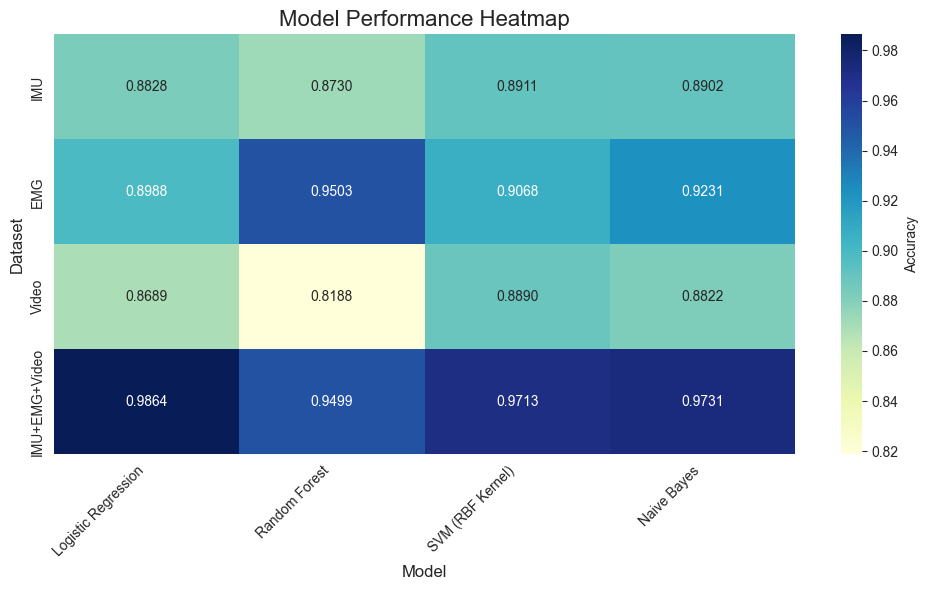

In [13]:
plot_results_heatmap(
    results_data=[results_imu["LOGOCV"], results_emg["LOGOCV"], results_video["LOGOCV"], results_all["LOGOCV"]],
    models=list(results_imu["LOGOCV"].keys()),
    datasets=["IMU", "EMG", "Video", "IMU+EMG+Video"],
    cv_type="LOGOCV"
)

## windows

In [14]:
df = pd.read_pickle("video_imu_emg_windows.pkl")
X = df.drop(columns=['Participant', 'Set', 'Window', 'Correct'])
y = df['Correct']
participants = df['Participant']

# Split into EMG, IMU, and Video based on column names
emg_columns = [col for col in X.columns if 'trapezius' in col or 'delt' in col]
video_columns = [col for col in X.columns if 'X' in col or 'Y' in col]
imu_columns = [col for col in X.columns if col not in emg_columns + video_columns]

X_emg = X[emg_columns]
X_video = X[video_columns]
X_imu = X[imu_columns]
X_imu_emg = X[imu_columns + emg_columns]
X_imu_video = X[imu_columns + video_columns]
X_emg_video = X[emg_columns + video_columns]
X_all = X  # All features (IMU + EMG + Video)


# Evaluate for IMU data
print("\nEvaluating IMU data:")
results_imu = evaluate_models_with_cv(X_imu, y, participants, k=25)

# Evaluate for EMG data
print("\nEvaluating EMG data:")
results_emg = evaluate_models_with_cv(X_emg, y, participants, k=25)

# Evaluate for Video data
print("\nEvaluating Video data:")
results_video = evaluate_models_with_cv(X_video, y, participants, k=25)

# Evaluate for Combined IMU+EMG data
print("\nEvaluating Combined IMU+EMG data:")
results_imu_emg = evaluate_models_with_cv(X_imu_emg, y, participants, k=25)

# Evaluate for Combined IMU+Video data
print("\nEvaluating Combined IMU+Video data:")
results_imu_video = evaluate_models_with_cv(X_imu_video, y, participants, k=25)

# Evaluate for Combined EMG+Video data
print("\nEvaluating Combined EMG+Video data:")
results_emg_video = evaluate_models_with_cv(X_emg_video, y, participants, k=25)

# Evaluate for All Features (IMU+EMG+Video)
print("\nEvaluating All Features (IMU+EMG+Video):")
results_all = evaluate_models_with_cv(X_all, y, participants, k=25)

all_results = {
    "IMU": results_imu,
    "EMG": results_emg,
    "Video": results_video,
    "IMU+EMG": results_imu_emg,
    "IMU+Video": results_imu_video,
    "EMG+Video": results_emg_video,
    "All Features (IMU+EMG+Video)": results_all,
}


Evaluating IMU data:

Evaluating models with LOGOCV...
Evaluating Logistic Regression...
Logistic Regression: Mean Accuracy = 0.8001 ± 0.1130
Evaluating Random Forest...
Random Forest: Mean Accuracy = 0.8085 ± 0.0882
Evaluating SVM (RBF Kernel)...
SVM (RBF Kernel): Mean Accuracy = 0.8083 ± 0.1239
Evaluating Naive Bayes...
Naive Bayes: Mean Accuracy = 0.7772 ± 0.1098

Evaluating models with 5-Fold...
Evaluating Logistic Regression...
Logistic Regression: Mean Accuracy = 0.9190 ± 0.0100
Evaluating Random Forest...
Random Forest: Mean Accuracy = 0.9259 ± 0.0145
Evaluating SVM (RBF Kernel)...
SVM (RBF Kernel): Mean Accuracy = 0.9236 ± 0.0090
Evaluating Naive Bayes...
Naive Bayes: Mean Accuracy = 0.8750 ± 0.0072

Evaluating EMG data:

Evaluating models with LOGOCV...
Evaluating Logistic Regression...
Logistic Regression: Mean Accuracy = 0.6356 ± 0.1952
Evaluating Random Forest...
Random Forest: Mean Accuracy = 0.6234 ± 0.1371
Evaluating SVM (RBF Kernel)...
SVM (RBF Kernel): Mean Accuracy =

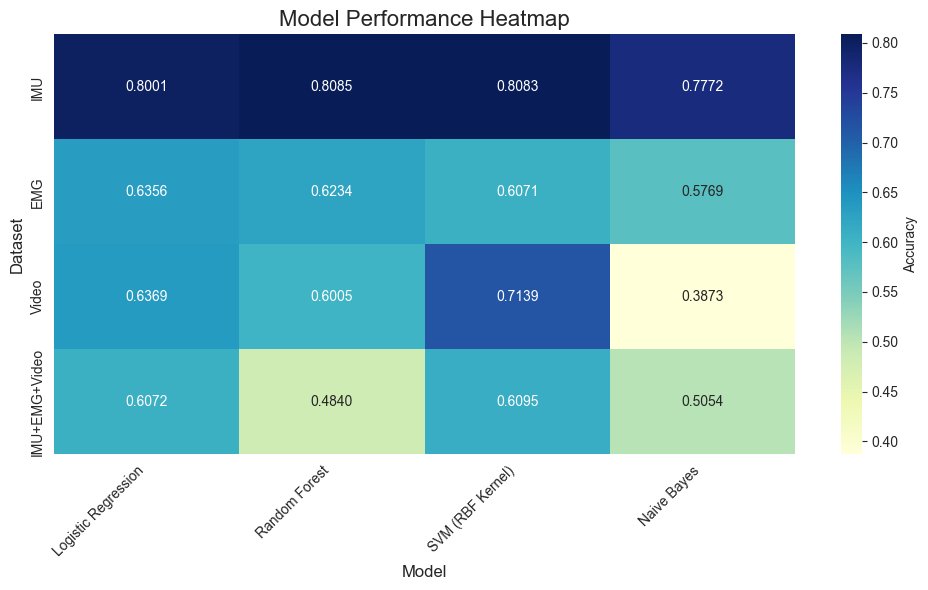

In [15]:
plot_results_heatmap(
    results_data=[results_imu["LOGOCV"], results_emg["LOGOCV"], results_video["LOGOCV"], results_all["LOGOCV"]],
    models=list(results_imu["LOGOCV"].keys()),
    datasets=["IMU", "EMG", "Video", "IMU+EMG+Video"],
    cv_type="LOGOCV"
)